In [32]:
# set-up ipython kernel
# python -m ipykernel install --name tfenv


import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!python --version

Python 3.9.13


In [5]:
tf.__version__

'2.10.1'

### *Import Data*

In [6]:
train_df = pd.read_csv('data/Train.csv')

test_df = pd.read_csv('data/Test.csv')

valid_df = pd.read_csv('data/Valid.csv')

In [7]:
train_df.shape

(40000, 2)

In [8]:
test_df.shape

(5000, 2)

In [9]:
valid_df.shape

(5000, 2)

In [10]:
train_df.head(3)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0


## Download pre-trained BERT preprocessor and BERT Model (encoder)

Before training a model using BERT, the text data needs to be first converted into machine-readable tokens in the form of tensors. To achieve this, a preprocessing model specifically created for BERT is used to translate English words into numerical values, which will give N tensors (N being the training sample size), each with a fixed length of 128 (this is by default, we may change the input sequence length to up to 512 tokens at maximum). A pre-trained BERT model is then used to generate outputs based on those preprocessed input (tensors). In our case, 'cased' BERT model is used, because it can recognize upper-cased letters in the context, which may be related to excitement or intentional emphasis on a specific word.

In [11]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2", trainable=True, name="BERT_encoder")
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='Pre-Processing')


*Test the preprocessor*

+ We can test how the preprocessor essentially works using simple input texts.
+ There are 3 outputs, namely the word id, input mask indicator and type id.
+ The word id vector simply gives the corresponding id for each word that is recognizable by BERT.
+ The input mask tells which token is masked (0) and which is not (1). 
+ The type id has the index of the input segment that gave rise to the input token at the respective position. In this case, because we only have one input sentence, the type id is a zero vector.

In [12]:
def test_process_model(input_text):
  t = [input_text]
  processed_t = bert_preprocess_model(t)
  print(f'Original text: {input_text}')
  print(f'Shape: {processed_t["input_word_ids"].shape}')
  print(f'Word Id: {processed_t["input_word_ids"][0,:12]}')
  print(f'Input Mask Indicator: {processed_t["input_mask"][0,:12]}')
  print(f'Type Id: {processed_t["input_type_ids"][0, :12]}')
  return

test_process_model('This is really a wonderful movie!')
print()
test_process_model('I really don\'t like this movie')


Original text: This is really a wonderful movie!
Shape: (1, 128)
Word Id: [ 101 2023 2003 2428 1037 6919 3185  999  102    0    0    0]
Input Mask Indicator: [1 1 1 1 1 1 1 1 1 0 0 0]
Type Id: [0 0 0 0 0 0 0 0 0 0 0 0]

Original text: I really don't like this movie
Shape: (1, 128)
Word Id: [ 101 1045 2428 2123 1005 1056 2066 2023 3185  102    0    0]
Input Mask Indicator: [1 1 1 1 1 1 1 1 1 1 0 0]
Type Id: [0 0 0 0 0 0 0 0 0 0 0 0]


In [13]:
def test_bert_model(input_text, output=False):
  t = [input_text]
  processed_t = bert_preprocess_model(t)
  bert_results = bert_encoder(processed_t)

  if output is False:
      print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
      print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :5]}')
  if output is True:
      return bert_results["pooled_output"]


test_bert_model('This is really a wonderful movie!')

Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.24430047  0.99493533 -0.06289306  0.3481398   0.51652336]


In [16]:
from sklearn.metrics.pairwise import cosine_similarity


embedding_1 = test_bert_model("Elon Musk", True)
embedding_2 = test_bert_model("Jeff Bezos", True)
embedding_3 = test_bert_model("University of California, Davis", True)

print(cosine_similarity(embedding_1, embedding_2))
print(cosine_similarity(embedding_2, embedding_3))


[[0.8590814]]
[[0.6185554]]


+ The above example illustrated how the dissimilarity of sentences (phrases, in this case) used in different context are calculated. Technically speaking, each word has, based on its context, a vector representation given by the pre-trained BERT. For two given texts, the cosine of their corresponding vector representations are calculated as a way to measure the contextual difference between the two words.
+ For "Elon Musk" and "Jeff Bezos", their contexts can be very similar as both of them are successful entrepreneurs.
+ "Elon Musk" and "University of California, Davis" are less similar in context, and thus have lower cosine similarity score.

# BERT model

### *Model Construction*

In [17]:
def build_classifier_model():

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Text')
  # preprocessing
  preprocessing_layer = bert_preprocess_model
  encoder_input = preprocessing_layer(text_input)
  # applying BERT
  encoder = bert_encoder
  outputs = encoder(encoder_input)

  net = outputs['pooled_output']
  # drop-out layer
  net = tf.keras.layers.Dropout(0.4, name='Drop-Out')(net)
  # applying sigmoid activation function
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='Classifier')(net)
  return tf.keras.Model(text_input, net)

### *Visualize the Structure*

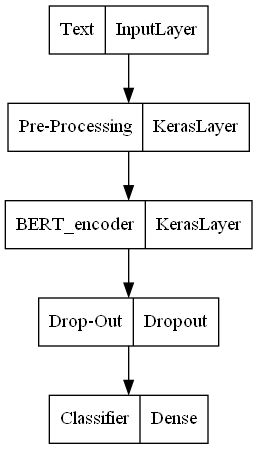

In [18]:
classifier_model = build_classifier_model()

tf.keras.utils.plot_model(classifier_model)

### *Compile & Train*



In [19]:
# metrics

metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

# optimizer

epochs = 5
batch_size = 64
steps_per_epoch = len(train_df)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

# loss
loss = tf.keras.losses.BinaryCrossentropy()


classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [20]:
train_X = train_df['text']
train_y = train_df['label']
valid_X = valid_df['text']
valid_y = valid_df['label']


model_history = classifier_model.fit(train_X, train_y, 
                                     validation_data = (valid_X, valid_y), epochs=epochs,
                                    batch_size=batch_size)

Epoch 1/5
625/625 [==============================] - 604s 957ms/step - loss: 0.5032 - accuracy: 0.7454 - precision: 0.7414 - recall: 0.7530 - val_loss: 0.3617 - val_accuracy: 0.8368 - val_precision: 0.8151 - val_recall: 0.8735
Epoch 2/5
625/625 [==============================] - 599s 958ms/step - loss: 0.3373 - accuracy: 0.8551 - precision: 0.8530 - recall: 0.8576 - val_loss: 0.3372 - val_accuracy: 0.8536 - val_precision: 0.8245 - val_recall: 0.9006
Epoch 3/5
625/625 [==============================] - 599s 958ms/step - loss: 0.2713 - accuracy: 0.8867 - precision: 0.8840 - recall: 0.8898 - val_loss: 0.3474 - val_accuracy: 0.8610 - val_precision: 0.8782 - val_recall: 0.8401
Epoch 4/5
625/625 [==============================] - 602s 964ms/step - loss: 0.2264 - accuracy: 0.9097 - precision: 0.9078 - recall: 0.9118 - val_loss: 0.3547 - val_accuracy: 0.8644 - val_precision: 0.8705 - val_recall: 0.8580
Epoch 5/5
625/625 [==============================] - 597s 955ms/step - loss: 0.1942 - accura

### *Model History*

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


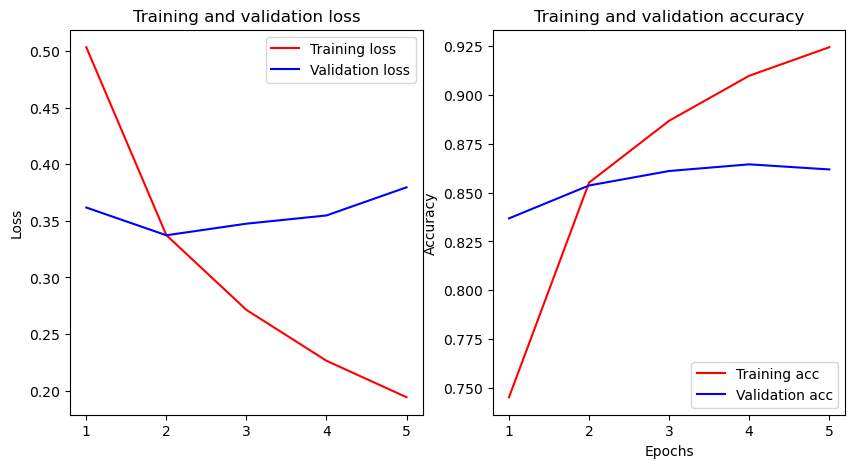

In [31]:
history_dict = model_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

prec = history_dict['precision']
val_prec = history_dict['val_precision']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.subplot(1, 2, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


### *Save Model*

In [22]:
classifier_model.save("./imdb_bert_model", include_optimizer=False)

INFO:tensorflow:Assets written to: ./imdb_bert_model\assets


INFO:tensorflow:Assets written to: ./imdb_bert_model\assets


### *Model Evaluation*

In [36]:
test_X = test_df['text']
test_y = test_df['label']


test_loss, test_acc, test_prec, test_recall = classifier_model.evaluate(test_X,test_y)


157/157 [==============================] - 32s 202ms/step - loss: 0.3543 - accuracy: 0.8708 - precision: 0.8670 - recall: 0.8766


In [39]:
def make_prediction(text):
    prob = classifier_model(tf.constant([text]))[0][0]
    if prob >= 0.5:
        return 1
    elif prob < 0.5:
        return 0

pred_y = test_X.apply(lambda x: make_prediction(x))

print(classification_report(y_true = test_y, y_pred = pred_y , target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      2495
    positive       0.87      0.88      0.87      2505

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



### *Experiment with Custom Text*

In [25]:
def get_score(text, model=classifier_model):
    score = model(tf.constant([text]))[0][0]
    print("Input text: {}".format(text))
    print()
    print("Score: {}".format(score))

#### Custom Positive Feedback

In [26]:
get_score("The movie was really great!")

Input text: The movie was really great!

Score: 0.9952241778373718


In [27]:
get_score("This film was a piece of art!")

Input text: This film was a piece of art!

Score: 0.9949047565460205


#### Positive Real Review on Avatar 2

In [40]:
get_score("If you loved the first movie, you are likely to love this too. \
          This movie too has a thin story, very basic dialogue, and has a very simplistic outlook on life and story. \
          And yet, again as the first one, this movie is beautiful, the story is about family and love, \
          and Cameron just know how to pull those strings. This is what Hollywood used to be so great at \
          and clearly Cameron is one of the last true directors of tinseltown.")

Input text: If you loved the first movie, you are likely to love this too.           This movie too has a thin story, very basic dialogue, and has a very simplistic outlook on life and story.           And yet, again as the first one, this movie is beautiful, the story is about family and love,           and Cameron just know how to pull those strings. This is what Hollywood used to be so great at           and clearly Cameron is one of the last true directors of tinseltown.

Score: 0.9201925992965698


#### Custom Negative Feedback

In [28]:
get_score("I kinda hate the main character...")

Input text: I kinda hate the main character...

Score: 0.010522437281906605


In [29]:
get_score("The movie was terrible...")

Input text: The movie was terrible...

Score: 0.0009527538786642253


#### Negative Real Review on Avatar 2

In [43]:
get_score("Story was a let down. Old wine in new bottle. Felt like they were reusing the first story at many places.\
They had like 13 years and still couldn't develop the story properly. Found some plot holes which contradicts the first movie.\
There were also many cliché scenes. And felt like the \"humours\" guys in the boat were bad actors. Took me out of the movie.\
Runtime was too much coz I felt bored. Overall it's an average movie. Still one time watchable. First movie is better in terms\
of story n visuals. This movie didn't have that balance.")

Input text: Story was a let down. Old wine in new bottle. Felt like they were reusing the first story at many places.They had like 13 years and still couldn't develop the story properly. Found some plot holes which contradicts the first movie.There were also many cliché scenes. And felt like the "humours" guys in the boat were bad actors. Took me out of the movie.Runtime was too much coz I felt bored. Overall it's an average movie. Still one time watchable. First movie is better in termsof story n visuals. This movie didn't have that balance.

Score: 0.0022504045628011227
